In [36]:
import os
import h2o
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.automl import H2OAutoML
from h2o.estimators import H2ODeepLearningEstimator, H2OAutoEncoderEstimator
from h2o.frame import H2OFrame

# H2O

## Inicializacion

In [37]:
#h2o.init(ip="172.25.197.59", port=54323)
h2o.init(nthreads=-1, max_mem_size="16G")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_452"; OpenJDK Runtime Environment (build 1.8.0_452-8u452-ga~us1-0ubuntu1~25.04-b09); OpenJDK 64-Bit Server VM (build 25.452-b09, mixed mode)
  Starting server from /home/giorgio6846/miniconda3/envs/BigData-TF/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpge0d23hg
  JVM stdout: /tmp/tmpge0d23hg/h2o_giorgio6846_started_from_python.out
  JVM stderr: /tmp/tmpge0d23hg/h2o_giorgio6846_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 15 days
H2O_cluster_name:,H2O_from_python_giorgio6846_ygzv70
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.21 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Carga de datos

In [38]:
# Prepare data for H2O
smb_dir = (
    "/mnt/sambashare/BigData-DATA/TF"
)
df_h2o = h2o.import_file(os.path.join(smb_dir, "processed", "yellow_tripdata_2016-03_processed.csv"))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Conversion de tablas categoricas

In [39]:
for col in ['store_and_fwd_flag', 'payment_type']:
    df_h2o[col] = df_h2o[col].asfactor()

## Descripcion del dataset entero

In [40]:
df_h2o.describe()

Rows:10886133
Cols:18

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup,dropoff,trip_duration_min
type,int,real,real,real,enum,real,real,enum,real,real,real,real,real,real,real,time,time,int
mins,0.0,0.0,-161.69866943359375,0.0,,-161.69866943359375,0.0,,0.0,-58.5,-1.0,0.0,0.0,0.0,0.0,1456790400000.0,1456790400000.0,-5.0
mean,1.6544602201718448,5.008883154376352,-72.9006436524518,40.15814214635303,,-72.9594841387262,40.19227866283195,,9.78226483178188,0.3348852076306618,0.49946400801827434,1.3254321089040506,0.012480849719546877,0.29995432170450415,12.254481327758915,1458118243747.071,1458118913302.8508,10.669024436868453
maxs,9.0,19072628.8,0.0,66.85681915283203,,0.0,50.7978630065918,,28.8,20.0,59.3,27.5,26.54,0.3,28.92,1459468799000.0,1459470676000.0,33.0
sigma,1.3098395929321303,6340.817768553748,8.87108352438827,4.886558035998738,,8.620024484973852,4.748454567785668,,4.6380936863267035,0.3746480907679032,0.024912710786969043,1.3091486463956896,0.27212929286655846,0.00369852918970667,5.299095582607836,771684416.2055813,771683689.6028124,6.509007594515269
zeros,310,51698,158829,158829,,149848,149848,,3233,5438386,11937,4023062,10861942,1652,1155,0,0,74078
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,2.5,-73.97674560546875,40.76515197753906,N,-74.00426483154297,40.74612808227539,1,9.0,0.5,0.5,2.05,0.0,0.3,12.35,2016-03-01 00:00:00,2016-03-01 00:07:55,7.0
1,1.0,2.9,-73.98348236083984,40.76792526245117,N,-74.00594329833984,40.7331657409668,1,11.0,0.5,0.5,3.05,0.0,0.3,15.35,2016-03-01 00:00:00,2016-03-01 00:11:06,11.0
2,6.0,5.72,-73.99458312988281,40.72784805297851,N,0.0,0.0,2,23.0,0.5,0.5,0.0,0.0,0.3,24.3,2016-03-01 00:00:00,2016-03-01 00:00:00,0.0


## Seleccion de muestra del dataset

In [41]:
t1, t2 = "trip_duration_min", "fare_amount"

ratio = 500000 / df_h2o.nrows
rand = df_h2o.runif(seed=42)

sampled = df_h2o[rand < ratio]
dataset_small = sampled[0:500000, :]

# EDA

## Descripcion de la muestra del dataset

In [42]:
dataset_small.describe()

Rows:499936
Cols:18

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup,dropoff,trip_duration_min
type,int,real,real,real,enum,real,real,enum,real,real,real,real,real,real,real,time,time,int
mins,0.0,0.0,-121.93335723876952,0.0,,-121.93329620361328,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1456790402000.0,1456790570000.0,0.0
mean,1.65588195288997,1.9560249311911924,-72.89953325153854,40.157497281569775,,-72.95313872015522,40.18877804639479,,9.778006024771171,0.33485486142226184,0.49947035220508246,1.3265147338859382,0.012866686935927798,0.29995113374512017,12.251663792965498,1458118780776.7698,1458119449905.0735,10.661132624976
maxs,9.0,29.2,0.0,44.262245178222656,,0.0,44.262245178222656,,28.58,4.0,3.0,25.0,24.0,0.3,28.9,1459468797000.0,1459470516000.0,33.0
sigma,1.3100744426995616,1.433530046961672,8.87587896467595,4.889132239380612,,8.646793907650473,4.763152965698006,,4.6366838193865485,0.3739100818042961,0.017224513869044625,1.3080321358146452,0.2771007527695223,0.0038227362092306152,5.2939387219613945,771463671.4091961,771462974.3294929,6.5023872643624125
zeros,17,2367,7302,7302,,6925,6925,,165,249601,544,184116,498794,81,62,0,0,3372
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,2.1,-73.97608947753906,40.75217056274414,N,-73.9874496459961,40.770782470703125,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,2016-03-01 00:00:02,2016-03-01 00:09:32,9.0
1,2.0,0.49,-73.9898681640625,40.757118225097656,N,-73.98538970947266,40.76319122314453,2,4.0,0.5,0.5,0.0,0.0,0.3,5.3,2016-03-01 00:00:05,2016-03-01 00:02:50,2.0
2,1.0,2.82,-73.97879028320312,40.76246643066406,N,-73.98910522460938,40.730716705322266,1,11.5,0.5,0.5,3.2,0.0,0.3,16.0,2016-03-01 00:00:17,2016-03-01 00:13:03,12.0


## Graficos

### Distribucion de la duracion de viaje

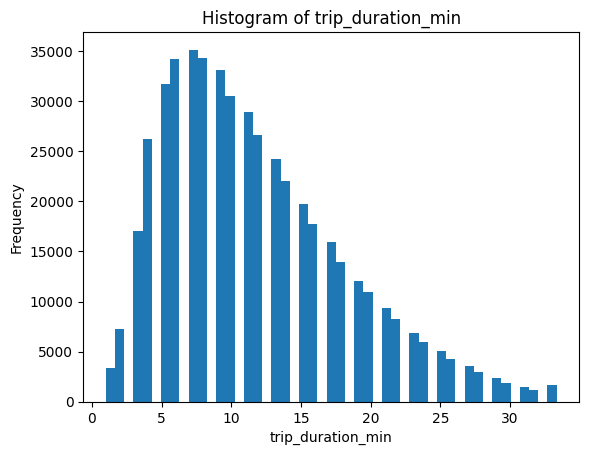

breaks,counts,mids_true,mids,widths
0.66,nan,nan,nan,nan
1.32,3372,0,0.99,0.66
1.98,7292,0.5,1.65,0.66
2.64,0,0,2.31,0.66
3.3,17045,1,2.97,0.66
3.96,26246,1.5,3.63,0.66
4.62,0,0,4.29,0.66
5.28,31691,2,4.95,0.66
5.94,34241,2.5,5.61,0.66
6.6,0,0,6.27,0.66


In [43]:
dataset_small['trip_duration_min'].hist(breaks=50)

### Distribucion del costo total

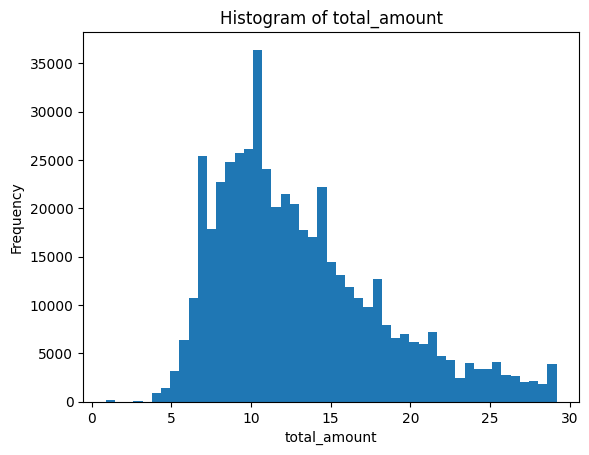

breaks,counts,mids_true,mids,widths
0.578,nan,nan,nan,nan
1.156,187,0,0.867,0.578
1.734,5,0.4,1.445,0.578
2.312,4,0.65,2.023,0.578
2.89,21,0.9,2.601,0.578
3.468,8,1.2,3.179,0.578
4.046,879,1.45,3.757,0.578
4.624,1436,1.78,4.335,0.578
5.202,3138,2.025,4.913,0.578
5.78,6331,2.35,5.491,0.578


In [44]:
dataset_small['total_amount'].hist(breaks=50)

# Entrenamiento

In [ ]:
# Select features for each model
# For trip duration, use mainly trip and location features
duration_features = [
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag'
]

# For fare amount, use trip, location, and payment-related features
fare_features = [
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'payment_type',
]

# Targets
target_duration = 'trip_duration_min'
target_fare = 'fare_amount'

# Split data
train, valid = dataset_small.split_frame(ratios=[0.8], seed=42)

# Model 1: Predict trip duration
aml_duration = H2OAutoML(max_models=20, seed=1, nfolds=5)
aml_duration.train(x=duration_features, y=target_duration, training_frame=train, validation_frame=valid)
duration_model = aml_duration.leader

# Model 2: Predict fare amount
aml_fare = H2OAutoML(max_models=20, seed=2, nfolds=5)
aml_fare.train(x=fare_features, y=target_fare, training_frame=train, validation_frame=valid)
fare_model = aml_fare.leader

AutoML progress: |
04:21:34.961: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
04:37:57.165: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


## Informacion de modelos seleccionados

### Modelo de duracion de viaje

#### Top 10 modelos

In [59]:
aml_duration.leaderboard.head(10)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250713_42134,3.62056,13.1085,2.6361,nan,13.1085
StackedEnsemble_BestOfFamily_1_AutoML_1_20250713_42134,3.64182,13.2628,2.6562,nan,13.2628
XGBoost_grid_1_AutoML_1_20250713_42134_model_3,3.6536,13.3488,2.66516,nan,13.3488
XGBoost_3_AutoML_1_20250713_42134,3.66954,13.4655,2.68143,nan,13.4655
XGBoost_grid_1_AutoML_1_20250713_42134_model_1,3.68424,13.5736,2.68706,nan,13.5736
GBM_1_AutoML_1_20250713_42134,3.69113,13.6244,2.70048,nan,13.6244
XGBoost_2_AutoML_1_20250713_42134,3.69427,13.6477,2.69137,nan,13.6477
XGBoost_grid_1_AutoML_1_20250713_42134_model_2,3.70405,13.72,2.6949,nan,13.72
GBM_4_AutoML_1_20250713_42134,3.73436,13.9454,2.74029,nan,13.9454
GBM_3_AutoML_1_20250713_42134,3.76479,14.1736,2.76842,nan,14.1736


In [46]:
duration_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/20
# GBM base models (used / total),1/7
# XGBoost base models (used / total),6/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


##### Modelo con mejor rendimiento

In [62]:
duration_model.model_id

'StackedEnsemble_AllModels_1_AutoML_1_20250713_42134'

##### Metricas

In [54]:
perf_duration = duration_model.model_performance(valid)
print('Trip Duration RMSE:', perf_duration.rmse())

Trip Duration RMSE: 3.599425506559351


In [55]:
perf_duration

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 12.95586397727004
RMSE: 3.599425506559351
MAE: 2.6254323414685508
RMSLE: NaN
Mean Residual Deviance: 12.95586397727004
R^2: 0.6928718986393632
Null degrees of freedom: 99751
Residual degrees of freedom: 99744
Null deviance: 4207990.207277003
Residual deviance: 1292373.343460641
AIC: 538621.4993431194

### Modelo de duracion de precio

#### Top 10 modelos

In [61]:
aml_fare.leaderboard.head(10)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20250713_43757,1.5812,2.50019,1.1148,0.149433,2.50019
StackedEnsemble_BestOfFamily_1_AutoML_2_20250713_43757,1.5971,2.55072,1.13166,nan,2.55072
XGBoost_3_AutoML_2_20250713_43757,1.60858,2.58754,1.13743,nan,2.58754
GBM_4_AutoML_2_20250713_43757,1.61126,2.59614,1.14467,0.152534,2.59614
XGBoost_2_AutoML_2_20250713_43757,1.61142,2.59667,1.13541,nan,2.59667
XGBoost_grid_1_AutoML_2_20250713_43757_model_2,1.61164,2.59739,1.13345,0.152078,2.59739
GBM_1_AutoML_2_20250713_43757,1.62248,2.63244,1.15017,0.152669,2.63244
GBM_3_AutoML_2_20250713_43757,1.62752,2.64881,1.15992,nan,2.64881
XGBoost_grid_1_AutoML_2_20250713_43757_model_1,1.6369,2.67943,1.16333,0.154895,2.67943
GBM_2_AutoML_2_20250713_43757,1.63838,2.6843,1.16955,nan,2.6843


In [56]:
fare_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),6/20
# GBM base models (used / total),2/7
# XGBoost base models (used / total),4/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


##### Modelo con mejor rendimiento

In [64]:
fare_model.model_id

'StackedEnsemble_AllModels_1_AutoML_2_20250713_43757'

##### Metricas

In [57]:
perf_fare = fare_model.model_performance(valid)
print('Fare Amount RMSE:', perf_fare.rmse())

Fare Amount RMSE: 1.5757554113340246


In [58]:
perf_fare

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 2.483005116348461
RMSE: 1.5757554113340246
MAE: 1.1102710024483144
RMSLE: 0.1480079827787611
Mean Residual Deviance: 2.483005116348461
R^2: 0.8849501391222914
Null degrees of freedom: 99751
Residual degrees of freedom: 99745
Null deviance: 2152881.3691191887
Residual deviance: 247684.7263659917
AIC: 373821.3213833343